In [12]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanIoU

In [13]:
# Load Stenosis annotation data
stenosis_train = pd.read_parquet("datasets/stenosis_train.parquet")
stenosis_val = pd.read_parquet("datasets/stenosis_val.parquet")
stenosis_test = pd.read_parquet("datasets/stenosis_test.parquet")

# Preview Stenosis annotation data
stenosis_train.head()

,image_id,segmentation,bbox,syntax_label
0,676,"[278.0, 291.75, 286.75, 299.25, 289.5, 296.25,...","[278.0, 245.12, 42.75, 54.13]",stenosis
1,960,"[294.75, 315.0, 293.0, 322.0, 298.5, 322.5, 30...","[293.0, 315.0, 68.0, 23.25]",stenosis
2,960,"[102.0, 172.25, 109.31, 179.25, 113.0, 175.75,...","[102.0, 157.38, 34.25, 21.87]",stenosis
3,960,"[87.69, 192.62, 96.69, 198.75, 95.81, 203.0, 9...","[84.38, 192.62, 12.31, 43.63]",stenosis
4,99,"[326.0, 232.62, 330.25, 231.38, 335.0, 239.75,...","[323.0, 221.25, 25.5, 26.13]",stenosis


In [14]:
# Helper function to load tensors from .tf files
def load_tensor_from_file(file_path):
    serialized_tensor = tf.io.read_file(file_path)
    tensor = tf.io.parse_tensor(serialized_tensor, out_type=tf.float32)
    return tensor

In [15]:
# Load tensors
X_train = load_tensor_from_file("datasets/X_train_stenosis.tf")
y_train = load_tensor_from_file("datasets/y_train_stenosis.tf")
X_val = load_tensor_from_file("datasets/X_val_stenosis.tf")
y_val = load_tensor_from_file("datasets/y_val_stenosis.tf")
X_test = load_tensor_from_file("datasets/X_test_stenosis.tf")
y_test = load_tensor_from_file("datasets/y_test_stenosis.tf")

In [16]:
#Build dice loss function
def dice_loss(y_true, y_pred):
    smooth = 1e-6  # To avoid division by zero
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [20]:
tf.keras.backend.clear_session()
input_shape = (256, 256, 1)

input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Encoder
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input_layer)
pool1 = layers.MaxPooling2D((2, 2), padding='same', name='pool1')(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(pool1)
pool2 = layers.MaxPooling2D((2, 2), padding='same', name='pool2')(conv2)
conv3 = layers.Conv2D(128, (5, 5), activation='relu', padding='same', name='conv3')(pool2)
pool3 = layers.MaxPooling2D((2, 2), padding='same', name='pool3')(conv3)

# Decoder
conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4')(pool3)
up1 = layers.UpSampling2D((2, 2), name='up1')(conv4)
conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv5')(up1)
up2 = layers.UpSampling2D((2, 2), name='up2')(conv5)
conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv6')(up2)
up3 = layers.UpSampling2D((2, 2), name='up3')(conv6)

# Output Layer
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output')(up3)

# Example usage
model = tf.keras.models.Model(inputs=input_layer, outputs=output, name='cnn')
model.compile(optimizer='adam', loss=dice_bce_loss, metrics=[MeanIoU(num_classes=2)])
model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up1 (UpSampling2D)              │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up2 (UpSampling2D)              │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up3 (UpSampling2D)              │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2D)                 │ (None, 256, 256, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,873 (1.77 MB)

 Trainable params: 463,873 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    x=X_train,
    y=tf.cast(y_train == 255, tf.float32),
    batch_size=32,
    epochs=10,
    validation_data=(X_val, tf.cast(y_val == 255, tf.float32))
)

Epoch 1/10
 8/82 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - loss: 1.3893 - mean_io_u: 0.4292

KeyboardInterrupt: 

In [16]:
y_pred = model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step


In [17]:
predicted_masks = (y_pred > 0.5).astype(np.float32)  # Use float32 for compatibility with TensorFlow

iou_metric = MeanIoU(num_classes=2)

# Update states with the ground truth and predictions
iou_metric.update_state(tf.cast(y_test == 255, tf.float32), predicted_masks)

# Get the IoU score
test_iou = iou_metric.result().numpy()
print(f"Test IoU: {test_iou}")

Test IoU: 0.37411776185035706


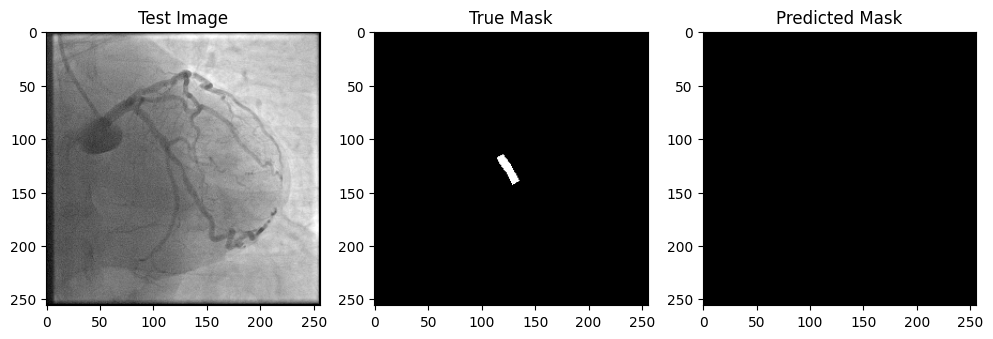

In [18]:
# Example: Visualize the first test image, its true mask, and the predicted mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(tf.squeeze(X_test[0]), cmap='gray')  # Use tf.squeeze
plt.title('Test Image')
plt.subplot(1, 3, 2)
plt.imshow(tf.squeeze(y_test[0]), cmap='gray')  # Use tf.squeeze
plt.title('True Mask')
plt.subplot(1, 3, 3)
plt.imshow(tf.squeeze(predicted_masks[0]), cmap='gray')  # Use tf.squeeze
plt.title('Predicted Mask')
plt.show()